In [1]:
import copy
import sre_parse
import sre_constants
from importlib import reload
from dataclasses import asdict
from typing import Tuple

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.markers import Path as MarkerPath
from matplotlib.transforms import Affine2D
from matplotlib.collections import PatchCollection
from ipywidgets import Accordion, HTML, VBox, HBox, Output, Button, Layout, Dropdown, Tab, Widget, GridBox, Text
from ipywidgets import Label, GridspecLayout
from tqdm import tqdm

In [34]:
import constants
reload(constants)
import solver
reload(solver)

<module 'solver' from '/data/Development/regex_crossword/solver.py'>

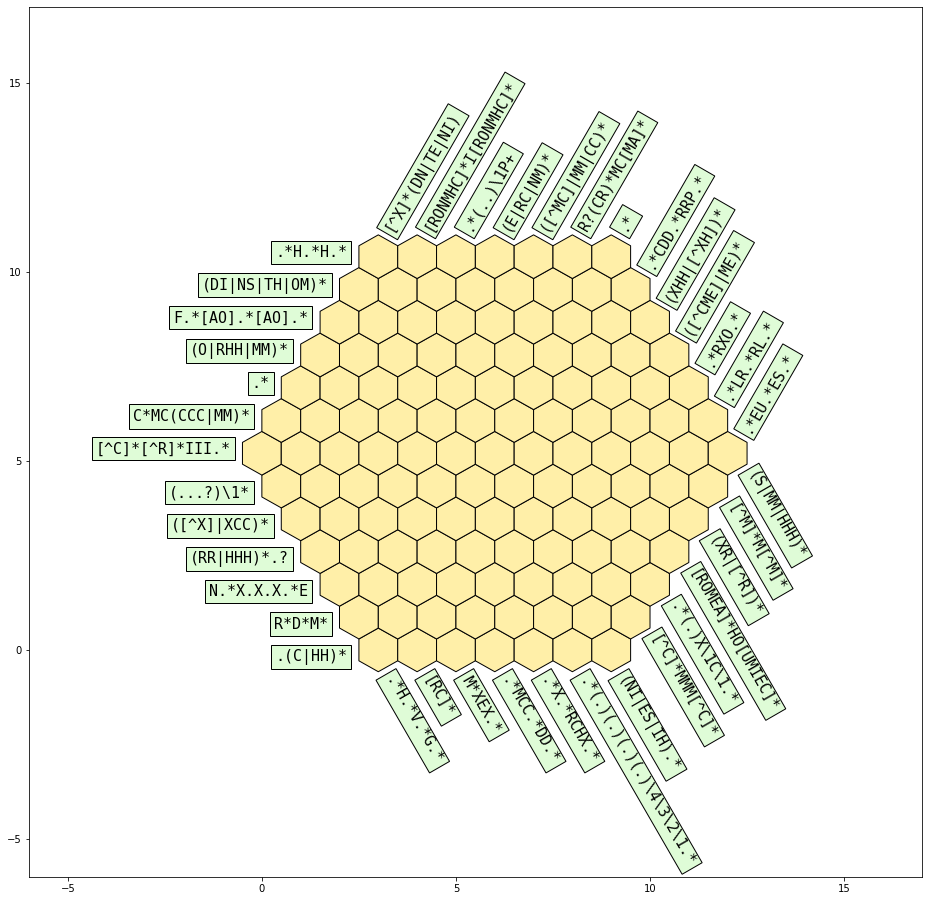

In [4]:
solver.draw_puzzel(fig_size=16, fontsize=15)

In [35]:
strings = solver.build_constraints()
len(strings)

39

In [13]:
strings

[<St pt='.*H.*H.*' cns=[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6)]>,
 <St pt='(DI|NS|TH|OM)*' cns=[(1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7)]>,
 <St pt='F.*[AO].*[AO].*' cns=[(2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8)]>,
 <St pt='(O|RHH|MM)*' cns=[(3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9)]>,
 <St pt='.*' cns=[(4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10)]>,
 <St pt='C*MC(CCC|MM)*' cns=[(5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11)]>,
 <St pt='[^C]*[^R]*III.*' cns=[(6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12)]>,
 <St pt='(...?)\\1*' cns=[(7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (7, 10), (7, 11)]>,
 <St pt='([^X]|XCC)*' cns=[(8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9

In [7]:
def widget_container(container_type, *labeled_children: Tuple[str, Widget]):
    titles, children = zip(*labeled_children)
    accordion = container_type(children)
    for i, t in enumerate(titles):
        accordion.set_title(i, t)
    return accordion

In [15]:
for x in strings[0].gen_possible():
    print(x)

FrozenInstanceError: cannot assign to field '_chr_seq'

In [24]:
import re
re.match(r'(AB|CD)*\1', 'ABCDCD')

<re.Match object; span=(0, 6), match='ABCDCD'>

In [36]:
widgets = []
with tqdm(strings) as t:
    for s in t:
        ps = list(s.gen_possible())
        output = Output()
        with output:
            display(asdict(s.pattern.re))
            print('Size', s.size)
            print('Span', s.pattern.re.span())
            print('Possible Matches')
            for m in ps:
                print(' ', m.chr_seq)
        widgets.append((f'{s.pattern.raw} sz={s.size} ps={len(ps)}', output))
    
widget_container(Accordion, *widgets)

100%|██████████| 39/39 [00:01<00:00, 20.16it/s]


Accordion(children=(Output(), Output(), Output(), Output(), Output(), Output(), Output(), Output(), Output(), …

In [ ]:
asdict(strings[0].pattern.re)

In [ ]:
pd.Series([len(s.positions) for s in strings]).value_counts()

In [ ]:
cells = list({id(c.cell):c.cell for s in strings for c in s.positions}.values())
len(cells)

In [ ]:
pd.Series([len(c.positions) for c in cells]).value_counts()

In [ ]:
positions = pd.DataFrame([
    {'str': s.pattern.pattern, 'cell': cells.index(c.cell), 'index': c.index }
    for s in strings for c in s.positions
])
positions

In [ ]:
assert len(positions.drop_duplicates()) == len(positions)

In [ ]:
c = cells[20]
print(c.position)
print(len(c.positions))
display([[cn.string.pattern.pattern, cn.index] for cn in c.positions])

In [ ]:
plt.plot()
for i, s in enumerate(constants.x):
    points = []
    start = max(0, i-mid)
    end = min(i + mid + 1, constants.size)
    for j in range(start, end):
        x = j
        y = i if j <= mid else mid + i - j
        points.append([x, y, y >= solver.row_size(x),
                       'b' if j <= mid else 'g'])
    x, y, inv, c = map(np.array, zip(*points))
    plt.scatter(x, y, c=c)
    plt.plot(x, y, 'k-')
    if any(inv):
        plt.scatter(x[inv], y[inv], c='r', marker='*', s=200)

    

In [ ]:
patterns = pd.DataFrame(
    [{'dim': dim, 'ix':ix, 'pat': pat}
        for dim, pats in constants.dims.items()
        for ix, pat in enumerate(pats)
    ])
patterns

In [ ]:
parsed = [sre_parse.parse(s) for s in patterns['pat']]

In [ ]:
patterns['low'], patterns['high'] = zip(*(p.getwidth() for p in parsed))

In [ ]:
patterns

In [ ]:
def gen_op_arg(pix, op, arg):
    yield dict(pix=pix, op=op, arg=arg)
    if op == sre_constants.SUBPATTERN:
        group, add_flags, del_flags, p = arg
        yield from gen_op_args(pix, p)
    elif op == sre_constants.MAX_REPEAT:
        mn, mx, p = arg
        yield from gen_op_args(pix, p)
    elif op == sre_constants.BRANCH:
        x, bs = arg
        assert x is None
        for b in bs:
            yield from gen_op_args(pix, b)
    elif op == sre_constants.IN:
        yield from gen_op_args(pix, arg)
        
        

def gen_op_args(pix, op_args):
    for op, arg in op_args:
        yield from gen_op_arg(pix, op, arg)
    

ops = pd.DataFrame([x
                    for pix,p in enumerate(parsed)
                    for x in gen_op_args(pix, p.data)],
                   dtype=object)
ops

In [ ]:
ops['op'].map(str).value_counts()

In [ ]:
ops.groupby('op').apply(lambda df : df.sample(min(5, len(df))))

In [ ]:
for _,row in ops[ops['op'] == sre_constants.IN].iterrows():
    display(row.to_frame().T)
    display(patterns.iloc[row['pix']].to_frame().T)
    display(row['arg'])
    print('-' * 80)

In [ ]:
for i,row in patterns.sample(n=10, random_state=0xCAFE).iterrows():
    display(row.to_frame().T)
    parsed[i].dump()
    print('-'*80)

In [ ]:
p = sre_parse.parse(constants.x[0])
p.dump()

In [ ]:
p.data

In [ ]:
p.getwidth()

In [ ]:
PatchCollection?

In [ ]:
[solver.row_size(i) for i in range(constants.size)]

In [ ]:
x,y = MarkerPath.unit_regular_polygon(6).vertices.T
plt.plot(x,y)

In [ ]:
1 / (x.max() - x.min())

In [ ]:
1 / (y.max() - y.min())

In [ ]:
0.577 / 0.5

In [ ]:
unit_hex = plt.Polygon(MarkerPath.unit_regular_polygon(6).vertices,
                       edgecolor='k', linewidth=1, fill=True, facecolor='#ffefa8')
unit_hex.set_transform(Affine2D().scale(0.577))

vscale = 1 / 1.154

def position(i, j):
    x = j + (constants.size - solver.row_size(i)) / 2.0
    y = i * vscale
    return x, y


patches = []
for i in range(constants.size):
    for j in range(solver.row_size(i)):
        x,y = position(i, j)
        patch = copy.copy(unit_hex)
        patch.set_transform(patch.get_transform() + Affine2D().translate(x, y))
        patches.append(patch)
        
p = PatchCollection(patches, match_original=True)


f = plt.figure(figsize=(11, 11))
ax = f.add_subplot(111)

ax.add_collection(p)

def text(x, y, s, **kwds):
    ax.text(x, y, s, fontsize=13, bbox=dict(facecolor='#dffcd7', edgecolor='k'), **kwds)

mid = constants.size // 2
for i,v in enumerate(constants.x[:mid + 1:]):
    x, y = position(12, i)
    text(x + 0.1, y + 0.7, v, rotation=60)
    
for i,v in enumerate(constants.x[mid + 1::]):
    r = constants.size - i - 1
    x, y = position(r, solver.row_size(r))
    text(x - 0.3, y - 0.3, v, rotation=60)
    
for i,v in enumerate(constants.y[:mid + 1:]):
    r = constants.size - i - 1
    x, y = position(r, 0)
    text(x - 0.8, y, v, horizontalalignment='right')
    
for i,v in enumerate(constants.y[mid + 1::]):
    r = mid - i - 1
    x, y = position(r, 0)
    text(x - 0.8, y - 0.3, v, horizontalalignment='right')
    
for i,v in enumerate(constants.z[:mid + 1:]):
    x, y = position(0, i)
    text(x + 0.15, y - 0.8, v, rotation=-60, rotation_mode='anchor')
    
for i,v in enumerate(constants.z[mid + 1::]):
    x, y = position(i, solver.row_size(i))
    text(x, y + 0.3, v, rotation=-60, rotation_mode='anchor')

ax.set_xlim(-5, 16)
ax.set_ylim(-5, 16)


In [ ]:
patch._transform._mtx

In [ ]:
vars(patch)

In [ ]:
ax.add_patch??